In [1]:
#https://github.com/ferchault/APDFT/issues/133
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src')
import apdft
from apdft.calculator.mrcc import MrccCalculator
import os
import numpy as np
from pyscf import gto
from pyscf.tools.cubegen import Cube
import scipy.interpolate as sci
import matplotlib.pyplot as plt

In [2]:
def read_file(bnpairs, mode):
    return pd.read_csv('data/ga-search-verbose/%d-%s.log' % (bnpairs, mode), sep=' ', names='gen value pattern'.split()).head(20000)

In [3]:
df = read_file(2, 'MAX')

[0.24947092 0.24947092 0.32670694 0.32670694 0.32670694 0.32670694
 0.32714749 0.32714749 0.32714749 0.37237599]


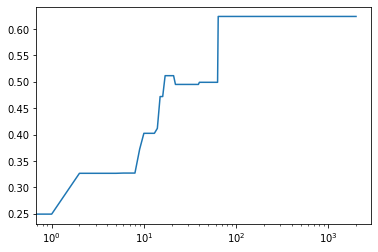

In [4]:
progress = df.groupby('gen').max()['value'].reset_index()
plt.plot(progress.gen,progress.value)
print (progress.value.values[:10])
plt.xscale('log')

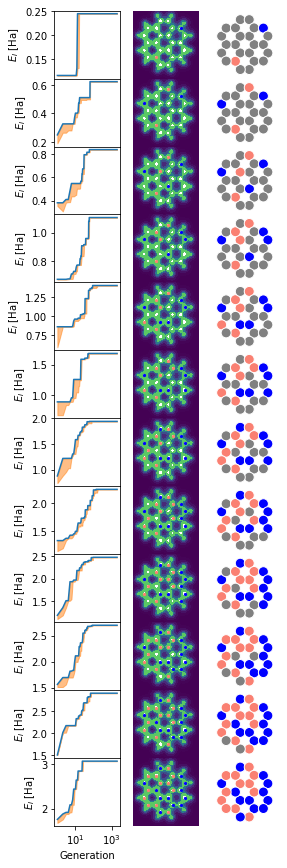

In [141]:
def build_figure(mode):
    if mode not in 'MIN MAX'.split():
        raise ValueError(mode)
    f, axs = plt.subplots(12, 3, figsize=(4, 15))
    for idx in range(12):
        df = read_file(idx+1, mode)
        if mode == 'MAX':
            progress = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            switchfunc = pd.Series.cummax
            bottom = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
        else:
            progress = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
            switchfunc = pd.Series.cummin
            bottom = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            
        axs[idx, 0].plot(progress.gen, switchfunc(progress.value), label='Best seen')
        axs[idx, 0].fill_between(bottom.gen, bottom.value, switchfunc(progress.value), color='C1', zorder=-10, alpha=0.5, label='Current population')
        axs[idx, 0].set_xscale('log')
        axs[idx, 0].set_ylabel(r'$E_I$ [Ha]')
        
        best_results = switchfunc(progress.value).values[-1]
        pattern = pattern_to_deltaZ(df[df.value == best_results].pattern.values[0])
        plot_density_into(axs[idx, 1], pattern)
        
        plot_molecule_into(axs[idx, 2], pattern)
        #break
    f.subplots_adjust(hspace=0)
    axs[11, 0].set_xlabel('Generation')
    
    plt.savefig('coronene-%s-generations.pdf' % mode, bbox_inches='tight')
    
build_figure('MAX')
#build_figure('MIN')

In [86]:
def pattern_to_deltaZ(pattern):
    values = pattern.split('.')
    values = [int(_) for _ in values]
    return np.array(values)
def plot_density_into(ax, deltaZ):
    basepath = 'data/coronene-dimer/mrcc-fast/'
    nuclear_numbers, coordinates = apdft.read_xyz(basepath + 'inp.xyz')
    path = 'data/validation-density/12-MIN-6-AB/'
    gridcoord, gridweights = MrccCalculator.get_grid(None, None, path)
    density = MrccCalculator.density_on_grid(path + 'DENSITY', gridcoord)
    yval = coordinates[:32, 1].mean()
    grid_x, grid_y = np.mgrid[-7:7:50j, -7:7:50j]
    gridded = sci.griddata(gridcoord, density, (grid_x, grid_x*0+yval, grid_y), method='nearest')
    levels = np.percentile(gridded, np.arange(0, 100, 8))
    ax.contourf(grid_x, grid_y, gridded, levels=levels)
    ax.scatter(coordinates[np.where(deltaZ > 0), 0], coordinates[np.where(deltaZ > 0), 2], color='blue', s=5)
    ax.scatter(coordinates[np.where(deltaZ < 0), 0], coordinates[np.where(deltaZ < 0), 2], color='salmon', s=5)
    #ax.plot((-5.2, -3.2), (-5, -5), lw=5, color='white')
    #ax.annotate(r'2 $\rm{\bf\AA}$', (-4.2, -4.8), ha='center', va='bottom', color='white', size='20', weight='bold')

    ax.set_xlim(-6.2, 5.2)
    ax.set_ylim(-6, 5.4)
    ax.axis('off')

In [120]:
def plot_molecule_into(ax, deltaZ):
    colors = {6: 'grey', 1: 'lightgrey', 7: 'blue', 8: 'red', 5: 'salmon'}
    outlinecolors = {6: 'white', 1: 'white', 7: 'white', 8: 'white', 5: 'white'}
    basepath = 'data/coronene-dimer/mrcc-fast/'
    nuclear_numbers, coordinates = apdft.read_xyz(basepath + 'inp.xyz')
    def draw_mol(coords, zs, cog, bonds):
        coords += cog - coords.mean(axis=0)
        dim = [0, 2]
        ax.scatter(coords[:, dim[0]], coords[:, dim[1]],edgecolors=[outlinecolors[_] for _ in zs], c=[colors[_] for _ in zs], s=100)
        def draw_bond(a, b, order):
            if order == 2:
                delta = coords[b, dim] - coords[a, dim]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.2
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                ax.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                ax.plot(xs, ys, color='black', zorder=-1)
            if order == 3:
                delta = coords[b, dim] - coords[a, dim]
                delta[1] *= -1
                delta = np.array((delta[1], delta[0]))
                delta /= np.linalg.norm(delta)
                shift = delta*0.3
                xs = coords[[a, b], 0] + shift[0]
                ys = coords[[a, b], 1] + shift[1]
                ax.plot(xs, ys, color='black', zorder=-1)
                xs = coords[[a, b], 0] - shift[0]
                ys = coords[[a, b], 1] - shift[1]
                ax.plot(xs, ys, color='black', zorder=-1)
                ax.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
            if order == 1:
                ax.plot(coords[[a, b], 0], coords[[a, b], 1], color='black', zorder=-1)
        #for aidx in range(c.natoms):
        #    axs.text(c.coordinates[aidx, 0], c.coordinates[aidx, 1], str(aidx))

        for afrom, ato, aorder in bonds:
            draw_bond(afrom, ato, aorder)
    bonds = tuple()
    draw_mol(coordinates[:24], nuclear_numbers[:24] + deltaZ, (0, 0, 0), bonds)
    
    D = 5
    ax.set_xlim(-D, D)
    ax.set_ylim(-D, D)
    ax.axis('off')

[-0.33354772215921, -0.6517898451020301, -0.9143328071966152, -1.277730748028489, -1.6688206016656295, -2.08872077834053, -2.442961208520046, -2.7936868875381156, -3.0636954016010804, -3.3517408365760275, -3.5552501059542014, -3.85081097350826]
[0.2453260725862947, 0.6235693241128502, 0.8382748301030458, 1.1065196925026155, 1.4038360896622637, 1.6890965944371599, 1.93838579873227, 2.2565421551946656, 2.476325306264471, 2.701753285289442, 2.9104896915112017, 3.072579843996891]


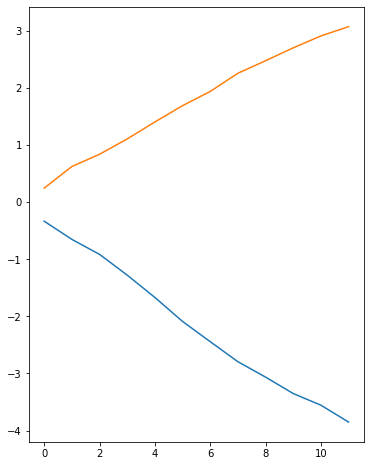

In [7]:
def build_figure():
    f, ax = plt.subplots(1, 1, figsize=(6,8))
    mins = []
    maxs = []
    for idx in range(12):
        df = read_file(idx+1, 'MIN')
        bottom = df.value.min()
        #print ('MIN', idx, df[df.value == bottom].pattern.values[0])
        df = read_file(idx+1, 'MAX')
        top = df.value.max()
        #print ('MAX', idx, df[df.value == top].pattern.values[0])
        
        mins.append(bottom)
        maxs.append(top)
    ax.plot(mins)
    ax.plot(maxs)
    print (mins)
    print (maxs)
    
build_figure()

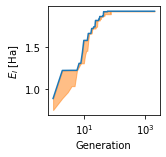

In [8]:
def build_figure(mode):
    if mode not in 'MIN MAX'.split():
        raise ValueError(mode)
    f, ax = plt.subplots(1, 1, figsize=(2, 2))
    for idx in range(6,7):
        df = read_file(idx+1, mode)
        if mode == 'MAX':
            progress = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            switchfunc = pd.Series.cummax
            bottom = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
        else:
            progress = df.query('gen > 0').groupby('gen').min()['value'].reset_index()
            switchfunc = pd.Series.cummin
            bottom = df.query('gen > 0').groupby('gen').max()['value'].reset_index()
            
        ax.plot(progress.gen, switchfunc(progress.value), label='Best seen')
        ax.fill_between(bottom.gen, bottom.value, switchfunc(progress.value), color='C1', zorder=-10, alpha=0.5, label='Current population')
        ax.set_xscale('log')
        ax.set_ylabel(r'$E_I$ [Ha]')
        
    f.subplots_adjust(hspace=0)
    ax.set_xlabel('Generation')
    #ax.legend()
    
    #plt.savefig('coronene-%s-curve.pdf' % mode, bbox_inches='tight')
    
build_figure('MAX')